<a href="https://colab.research.google.com/github/itanvir/time-series-forecasting-lstm/blob/master/stock_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'  'How to get started with Drive.pdf'	 Share


In [112]:
!ls "/content/drive/My Drive/Colab Notebooks"

time-series-forecasting-lstm


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read data
stock_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/time-series-forecasting-lstm/data/google_historical_quotes.csv")
stock_df["average"] = (stock_df["high"] + stock_df["low"])/2
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df = stock_df.sort_values(by='date')

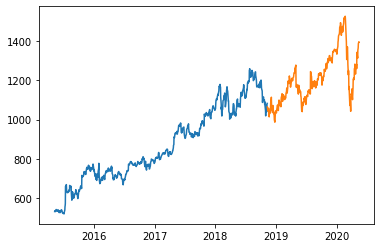

In [114]:
# Train/test split
test_size=int(.3 * len(df))
train_df = stock_df[0:-test_size:]
test_df = stock_df[-test_size:]

# Let's also plot
plt.plot(train_df['date'], train_df['average'])
plt.plot(test_df['date'], test_df['average'])

In [0]:
# Only volume and average data will be used
train_df = train_df[['volume', 'average']]
test_df = test_df[['volume', 'average']]

# Scaling using training data
from sklearn.preprocessing import MinMaxScaler
scaler_data = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler_data.fit(train_df)
train_data = scaler_data.transform(train_df)
test_data = scaler_data.transform(test_df)

# Create scaler_y for inverting ypred
scaler_y = MinMaxScaler(feature_range=(0,1))
scaler_y = scaler_y.fit(train_df['average'].values.reshape(-1, 1) )

In [116]:
# Lookback previous 50 business days
def build_lookback_series(data_array):
  lookback= 50

  X=[]
  y=[]
  for i in range(len(data_array)-lookback-1):
      t=[]
      for j in range(0,lookback):
          
          t.append(data_array[[(i+j)], :])
      X.append(t)
      y.append(data_array[i+ lookback,1])

  X, y = np.array(X), np.array(y)

  X = np.squeeze(X)
  y = np.squeeze(y)

  return X, y

X_train, y_train = build_lookback_series(train_data)
X_test, y_test = build_lookback_series(test_data)

print(X_train.shape)
print(X_test.shape)

(831, 50, 2)
(326, 50, 2)


In [117]:
# Input shape for LSTM (nlookbacks x nfeatures)
input_shape = (X_train.shape[1],2)
print (input_shape)

(50, 2)


In [118]:
from keras import Sequential
from keras.layers import Dense, LSTM

# Model architecture
model = Sequential()
model.add(LSTM(units=30, return_sequences = True, input_shape = input_shape))
model.add(LSTM(units=30, return_sequences = True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Compile and fit
np.random.seed(0) # for reproducibility
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=200, batch_size=256)

Epoch 1/200
831/831 [==============================] - 2s 3ms/step - loss: 0.0028
Epoch 2/200
831/831 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 3/200
831/831 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 4/200
831/831 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 5/200
831/831 [==============================] - 1s 2ms/step - loss: 0.0013
Epoch 6/200
831/831 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 7/200
831/831 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 8/200
831/831 [==============================] - 1s 2ms/step - loss: 9.9944e-04
Epoch 9/200
831/831 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 10/200
831/831 [==============================] - 1s 2ms/step - loss: 9.8800e-04
Epoch 11/200
831/831 [==============================] - 1s 2ms/step - loss: 9.8189e-04
Epoch 12/200
831/831 [==============================] - 1s 2ms/step - loss: 9.7663e-

Text(0, 0.5, 'Stock Price')

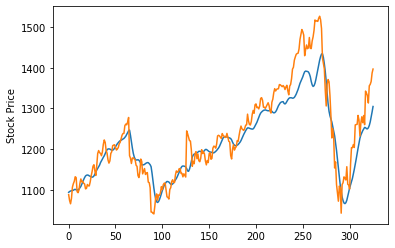

In [120]:
# Prediction
y_pred = model.predict(X_test)

# Inverse to original values
y_pred_inv = np.squeeze(scaler_y.inverse_transform(y_pred.reshape(-1, 1)))
y_test_inv = np.squeeze(scaler_y.inverse_transform(y_test.reshape(-1, 1)))

# Plot
plt.plot(y_pred_inv)
plt.plot(y_test_inv)
plt.ylabel('Stock Price')

Text(0, 0.5, 'Percent Error')

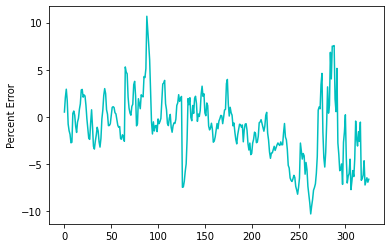

In [121]:
plt.plot((y_pred_inv-y_test_inv)/y_test_inv*100.0, 'c')
plt.ylabel('Percent Error')